<a href="https://colab.research.google.com/github/y-oth/dst_assessment2/blob/main/SHAPImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SHAP Implementation

I read about SHAP in the medium blog https://michaeltang101.medium.com/simple-convolutional-neural-network-with-shap-4fc473472a6d and then here try to implement the same method as used in their corresponding GitHub https://github.com/MTang0728/SimpleCNN-with-SHAP/blob/main/Simple_CNN.ipynb for our Brain Tumour dataset. I initally ran into issues because..

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!unzip "/content/drive/MyDrive/DST/archive.zip" -d "/content/data"

Archive:  /content/drive/MyDrive/DST/archive.zip
replace /content/data/Testing/glioma_tumor/image(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
# set seed
torch.manual_seed(0)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# install shap
# !pip install shap
import shap

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# THIS NEURAL NETWORK IS EXACTLY THE ONE IN THE GITHUB

class Simple_NN(nn.Module):
    def __init__(self):
        super(Simple_NN, self).__init__()
        self.conv_sec = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.fc_sec = nn.Sequential(
            nn.Linear(16*54*54, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 4) # changed this final line to 4 outputs instead of the 3
        )

    def forward(self, x):
        conv_out = self.conv_sec(x)
        flatten_out = conv_out.view(-1, 16*54*54)
        fc_out = self.fc_sec(flatten_out)

        return fc_out
# instantiate the network and add to device
model = Simple_NN().to(device)


device: cpu


## Dataloaders

In [24]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


TRAIN_DATA_ROOT = "/content/drive/MyDrive/DST/mridatafull/Training"
VAL_DATA_ROOT   = "/content/drive/MyDrive/DST/mridatafull/Testing"

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# transformation for SHAP (NO normalization!)
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

base_dataset = datasets.ImageFolder(
    TRAIN_DATA_ROOT,
    transform=base_transform
)

base_loader = torch.utils.data.DataLoader(
    base_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4
)



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [18]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

train_dataset = datasets.ImageFolder("/content/data/Training", transform=transform)
test_dataset  = datasets.ImageFolder("/content/data/Testing",  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [19]:
# create loss function
criterion = nn.CrossEntropyLoss().to(device)
# Add optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
# total number of training epochs
EPOCHS = 10
# define lists for tracking performance
train_acc = []
val_acc = []
train_loss_list = []
val_loss_list = []

print("==> Training starts!")
print("="*50)

for i in range(0, EPOCHS):
    # switch to train mode
    model.train()
    print("Epoch %d:" %i)
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # compute the output and loss
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # zero the gradient
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()

        total_examples += targets.shape[0]
        train_loss += loss
        correct_examples += correct.item()

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_loss_list.append(float(avg_loss.detach().cpu().numpy()))
    train_acc.append(avg_acc)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    # switch to eval mode
    model.eval()
    total_examples = 0
    correct_examples = 0
    val_loss = 0 # again, track the validation loss if you want
    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # compute the output and loss
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()

            total_examples += targets.shape[0]
            val_loss += loss
            correct_examples += correct.item()

    avg_loss = val_loss / len(test_loader)
    avg_acc = correct_examples / total_examples
    val_loss_list.append(float(avg_loss.detach().cpu().numpy()))
    val_acc.append(avg_acc)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

==> Training starts!
Epoch 0:
Training loss: 0.7964, Training accuracy: 0.6585
Validation loss: 1.5958, Validation accuracy: 0.4670
Epoch 1:
Training loss: 0.4375, Training accuracy: 0.8118
Validation loss: 2.1211, Validation accuracy: 0.5254
Epoch 2:
Training loss: 0.3158, Training accuracy: 0.8739
Validation loss: 2.2250, Validation accuracy: 0.6269
Epoch 3:
Training loss: 0.1871, Training accuracy: 0.9341
Validation loss: 3.0465, Validation accuracy: 0.6269
Epoch 4:
Training loss: 0.0903, Training accuracy: 0.9655
Validation loss: 3.9330, Validation accuracy: 0.6421
Epoch 5:
Training loss: 0.0831, Training accuracy: 0.9728
Validation loss: 2.4734, Validation accuracy: 0.7056
Epoch 6:
Training loss: 0.0431, Training accuracy: 0.9878
Validation loss: 3.1132, Validation accuracy: 0.7487
Epoch 7:
Training loss: 0.0261, Training accuracy: 0.9920
Validation loss: 2.7178, Validation accuracy: 0.7360
Epoch 8:
Training loss: 0.0083, Training accuracy: 0.9983
Validation loss: 3.0247, Validati

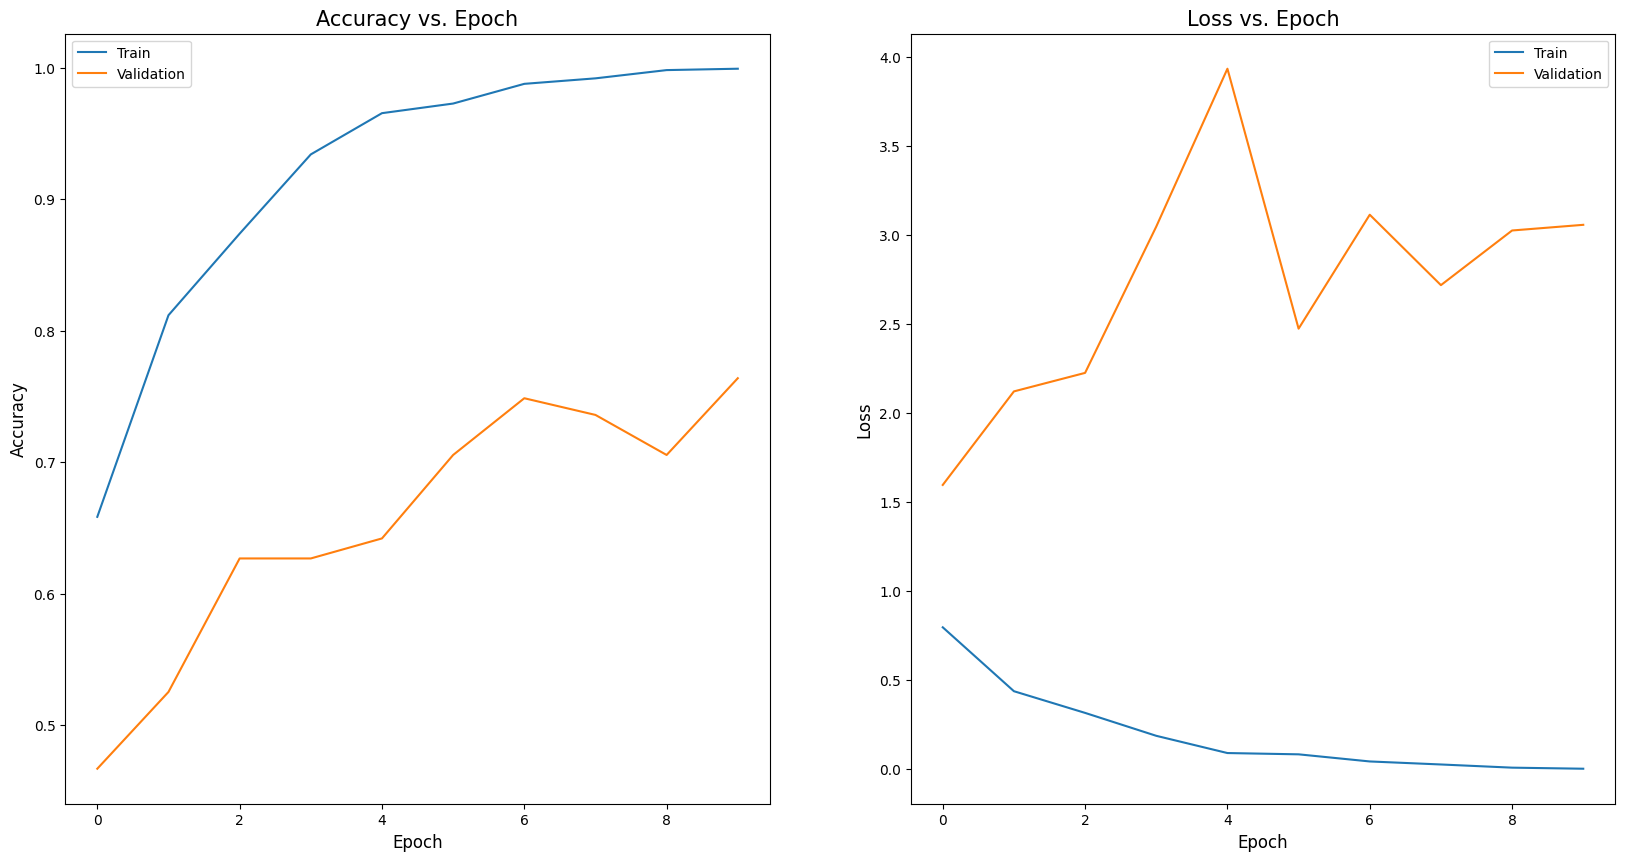

In [21]:
# plot accraucy and loss for both train and validation data
plt.figure(figsize = (20, 10))
plt.subplot(1, 2, 1)
sns.lineplot(x = np.arange(10), y = train_acc, label = 'Train')
sns.lineplot(x = np.arange(10), y = val_acc, label = 'Validation')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.title('Accuracy vs. Epoch', fontsize = 15)
plt.subplot(1, 2, 2)
sns.lineplot(x = np.arange(10), y = train_loss_list, label = 'Train')
sns.lineplot(x = np.arange(10), y = val_loss_list, label = 'Validation')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.title('Loss vs. Epoch', fontsize = 15)
plt.show()


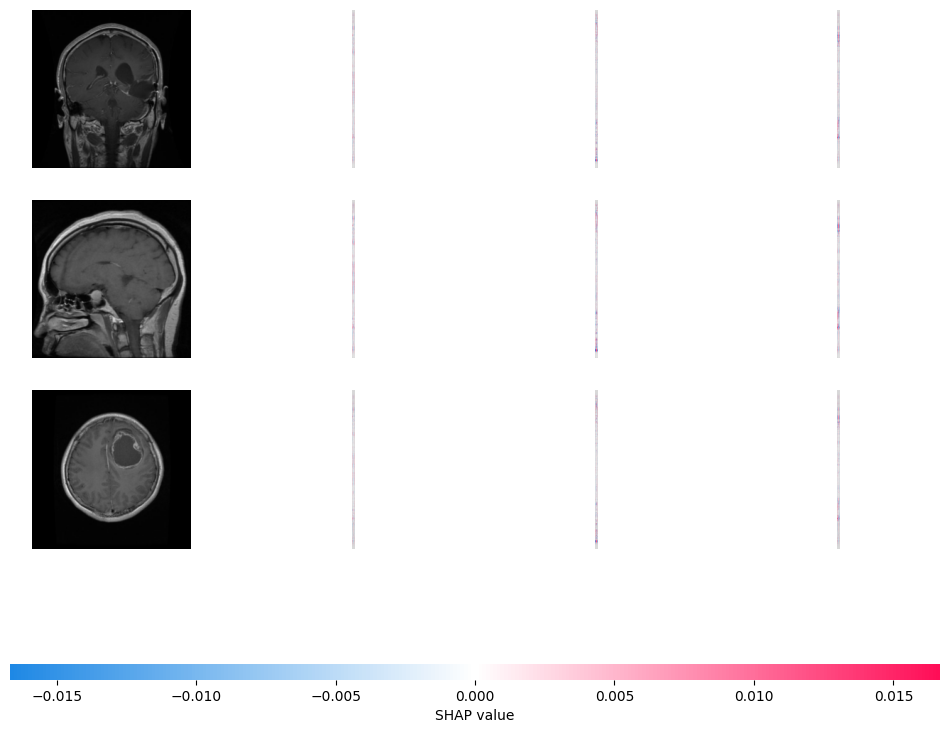

In [25]:
import shap
import numpy as np

batch = next(iter(base_loader))
images, labels = batch

# Move to device
background = images[:61].to(device)
test_images = images[61:64].to(device)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

# Convert to HWC for SHAP
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy)


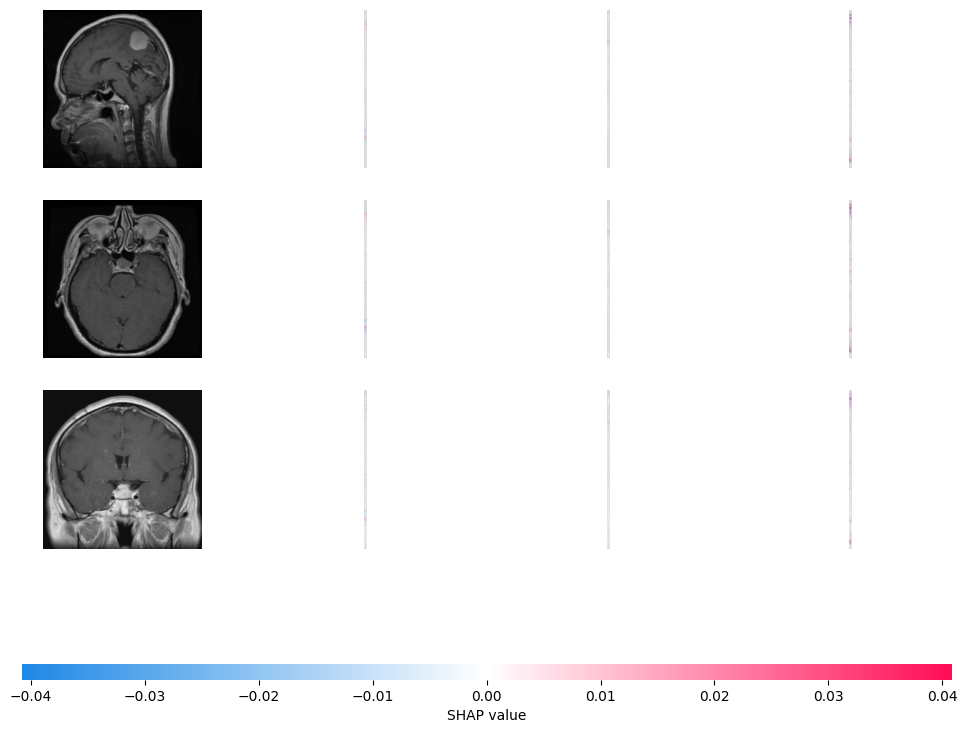

In [26]:
import shap
import numpy as np

# Undo normalization
mean = torch.tensor([0.5946, 0.5732, 0.5126], device=device).view(1,3,1,1)
std  = torch.tensor([0.2671, 0.2737, 0.3058], device=device).view(1,3,1,1)

batch = next(iter(base_loader))
images, labels = batch
images = images.to(device)

images_unnorm = images  # base_loader already removes normalization

background = images_unnorm[:20]
test_images = images_unnorm[20:23]

e = shap.GradientExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, test_numpy)
